# FIN41360 Report Notebook (Thin Workflow)

This notebook is intentionally thin: each section calls a named workflow and plotting function.

In [1]:
import seaborn as sns

from fin41360.process_french import load_industry_30_monthly, load_ff3_monthly, load_ff5_monthly
from fin41360.stock_data import load_stock_returns_monthly
from fin41360.workflows import (
    run_scope2_industries_sample_vs_bs,
    run_scope3_industries_vs_stocks,
    run_scope3_sensitivity_with_and_without_coal,
    run_scope4_industries_with_rf,
    run_scope5_industries_vs_ff,
    run_scope6_ff_vs_proxies,
    run_scope7_is_oos_tests,
)
from fin41360.plot_frontiers import (
    plot_scope2_overlay,
    plot_scope3_overlay,
    plot_scope4_with_rf,
    plot_scope5_overlay,
    plot_scope6_panels,
    plot_scope6_overlay,
)

sns.set_theme(style='whitegrid', context='notebook')

In [2]:
# Top-level plotting defaults (change here, applies to all sections)
PLOT_DEFAULTS = {
    "x_mode": "frontier",  # options: frontier | tangency | max
    "y_mode": "frontier",  # options: frontier | tangency | max
    "frontier_mult": 1.2,
    "tan_mult": 2.0,
    "efficient_frontier_only": True,
}
PLOT_DEFAULTS

{'x_mode': 'frontier',
 'y_mode': 'frontier',
 'frontier_mult': 1.2,
 'tan_mult': 2.0,
 'efficient_frontier_only': True}

In [3]:
# Shared data loads
ind = load_industry_30_monthly(start='1980-01', end='2025-12')
ff3, rf_gross = load_ff3_monthly(start='1980-01', end='2025-12')
ff5, rf_gross_ff5 = load_ff5_monthly(start='1980-01', end='2025-12')
stocks = load_stock_returns_monthly(start='1980-01', end='2025-12', use_cache=True, source='auto')
print('Industries:', ind.shape, ind.index.min().date(), 'to', ind.index.max().date())
print('FF3:', ff3.shape, 'FF5:', ff5.shape, 'RF:', len(rf_gross))
print('Stocks:', stocks.shape, stocks.index.min().date(), 'to', stocks.index.max().date())
print('Stock source:', stocks.attrs.get('stock_source'))
print('Stock source file:', stocks.attrs.get('stock_source_file'))

Industries: (552, 30) 1980-01-31 to 2025-12-31
FF3: (552, 3) FF5: (552, 5) RF: 552
Stocks: (551, 30) 1980-01-31 to 2025-11-30
Stock source: scope3_selected_cached_gross
Stock source file: fin41360_data/processed/scope3_selected_30_stock_monthly_gross.csv


## Scope 2 - 30 Industries (Sample vs Bayes-Stein)

In [4]:
scope2 = run_scope2_industries_sample_vs_bs(ind, rf_gross, cov_shrink=0.1)
scope2['inputs']

{'start': '1980-01',
 'end': '2025-12',
 'n_obs': 552,
 'n_assets': 30,
 'rf_mean': 0.003297282608695647}

In [5]:
scope2['summary_tables']['gmv_tan']

,label,universe,portfolio,mean,vol,excess_mean,sharpe
0,sample,industries,GMV,0.009733,0.031396,0.006435,0.204973
1,sample,industries,TAN,0.017633,0.046860,0.014336,0.305928
2,bs_mean,industries,GMV,0.009738,0.031396,0.006441,0.205144
3,bs_mean,industries,TAN,0.017556,0.046715,0.014259,0.305236
4,bs_mean_cov,industries,GMV,0.010071,0.032117,0.006773,0.210897
5,bs_mean_cov,industries,TAN,0.015950,0.043897,0.012653,0.288244


In [6]:
scope2['diagnostics']

{'bs_mean_shrinkage_intensity': 0.004790652563936337,
 'bs_target_mean': 0.010853484299516911,
 'sample_cov_eig_min': 0.000297211524494429,
 'sample_cov_eig_max': 0.07046386709080654,
 'bs_cov_eig_min': 0.0006789347421867802,
 'bs_cov_eig_max': 0.06382892475186769}

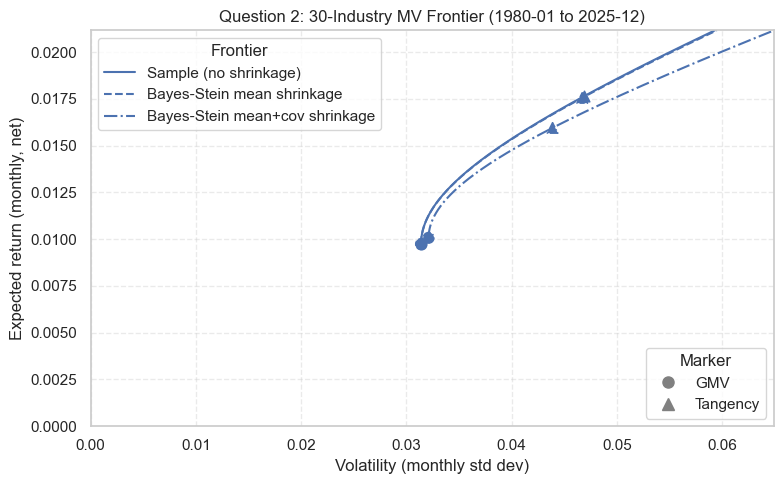

In [7]:
_ = plot_scope2_overlay(scope2, **PLOT_DEFAULTS)


## Scope 3 - 30 Industries vs 30 Stocks (Common Sample)

In [8]:
scope3_sensitivity = run_scope3_sensitivity_with_and_without_coal(
    ind_gross=ind,
    stocks_gross=stocks,
    rf_gross=rf_gross,
    cov_shrink=0.1,
)
scope3_with_coal = scope3_sensitivity['with_coal_30']
scope3_drop_coal = scope3_sensitivity['drop_coal_29']
scope3_window_summary = scope3_sensitivity['industry_stability']['summary_window_table']
scope3 = scope3_with_coal  # keep baseline alias for backward compatibility
scope3_sensitivity['diagnostics']


{'coal_stock_column_dropped': 'Coal',
 'rationale': 'with_coal_30 preserves full FF30 breadth but can force a shorter common window; drop_coal_29 relaxes breadth by one industry to recover a longer common sample.'}

In [9]:
scope3_window_summary


,scenario,common_start,common_end,n_obs,n_assets_industry,n_assets_stock,bs_industry_shrinkage_intensity,bs_stock_shrinkage_intensity
0,with_coal_30,2017-05,2025-11,103,30,30,0.003804,0.010809
1,drop_coal_29,1992-05,2025-11,403,29,29,0.003719,0.013250


In [10]:
import pandas as pd

scope3_compare = pd.concat([
    scope3_with_coal['summary_tables']['gmv_tan'].assign(scenario='with_coal_30'),
    scope3_drop_coal['summary_tables']['gmv_tan'].assign(scenario='drop_coal_29'),
], ignore_index=True)
scope3_compare


,estimator,universe,portfolio,mean,vol,excess_mean,sharpe,scenario
0,sample,industry,GMV,0.005841,0.028215,0.003881,0.137554,with_coal_30
1,sample,industry,TAN,0.123911,0.158159,0.121951,0.771065,with_coal_30
2,sample,stock,GMV,0.011890,0.032069,0.009930,0.309642,with_coal_30
3,sample,stock,TAN,0.046340,0.067796,0.044379,0.654599,with_coal_30
4,bs_mean,industry,GMV,0.005860,0.028215,0.003900,0.138232,with_coal_30
5,bs_mean,industry,TAN,0.122459,0.156828,0.120499,0.768347,with_coal_30
6,bs_mean,stock,GMV,0.011884,0.032069,0.009923,0.309435,with_coal_30
7,bs_mean,stock,TAN,0.045615,0.067263,0.043655,0.649015,with_coal_30
8,bs_mean_cov,industry,GMV,0.007417,0.030469,0.005456,0.179082,with_coal_30
9,bs_mean_cov,industry,TAN,0.062975,0.101887,0.061014,0.598843,with_coal_30


Text(0.5, 1.0, 'Question 3: 29 Industries vs 29 Stocks (1992-05 to 2025-11) [limits: Scope 2]')

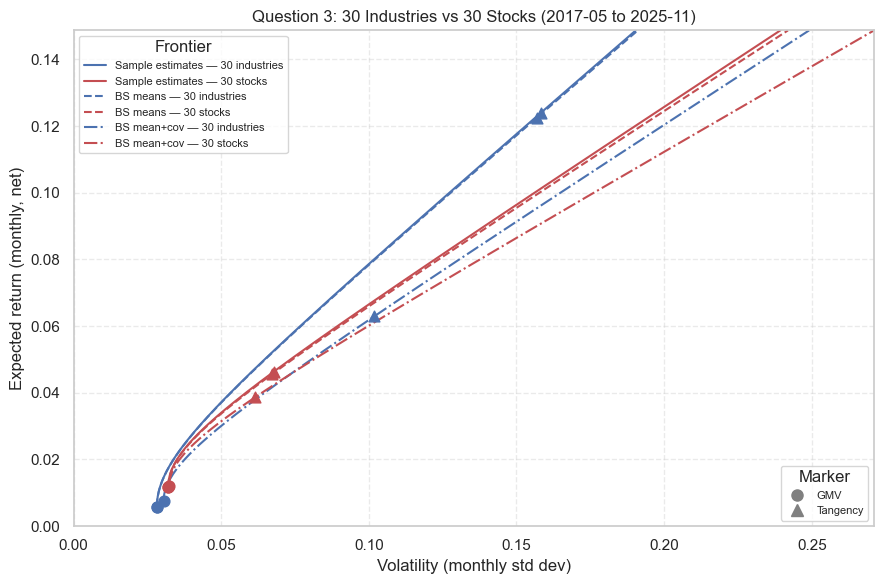

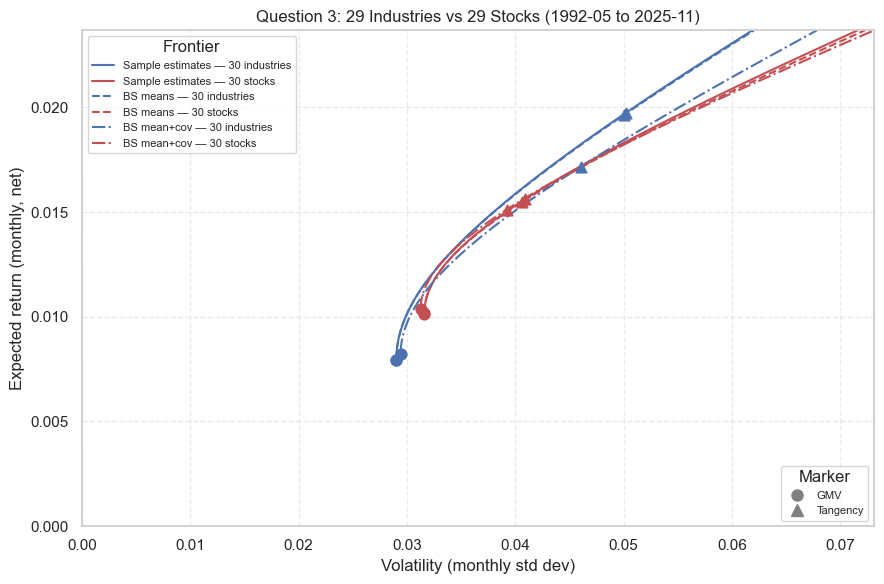

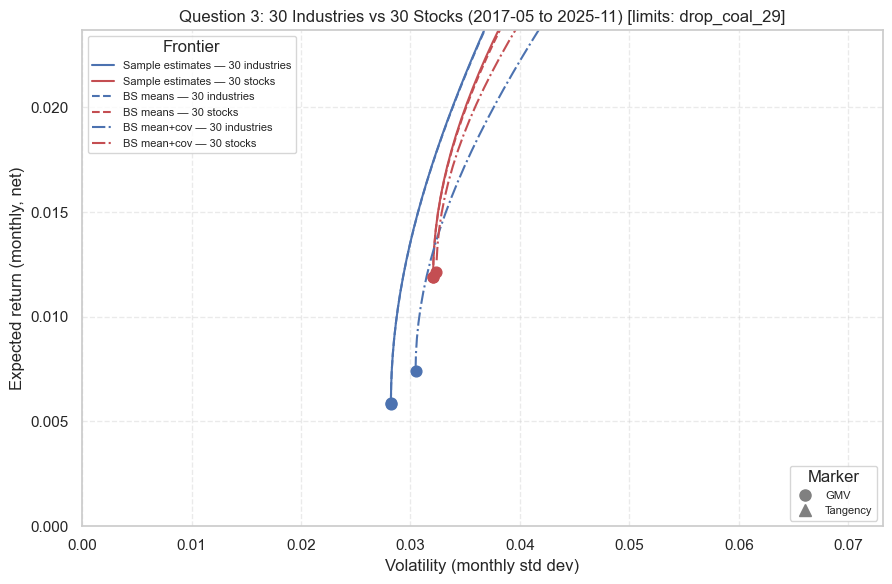

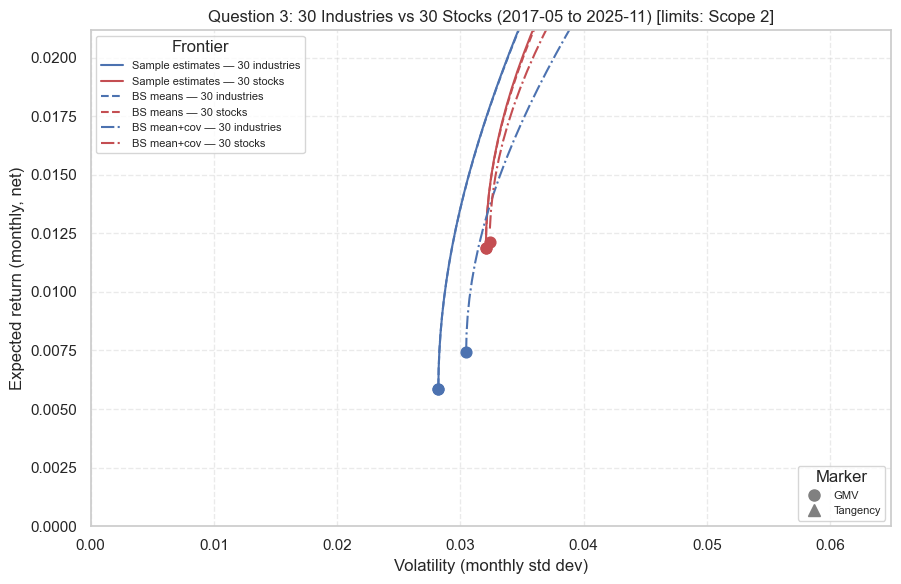

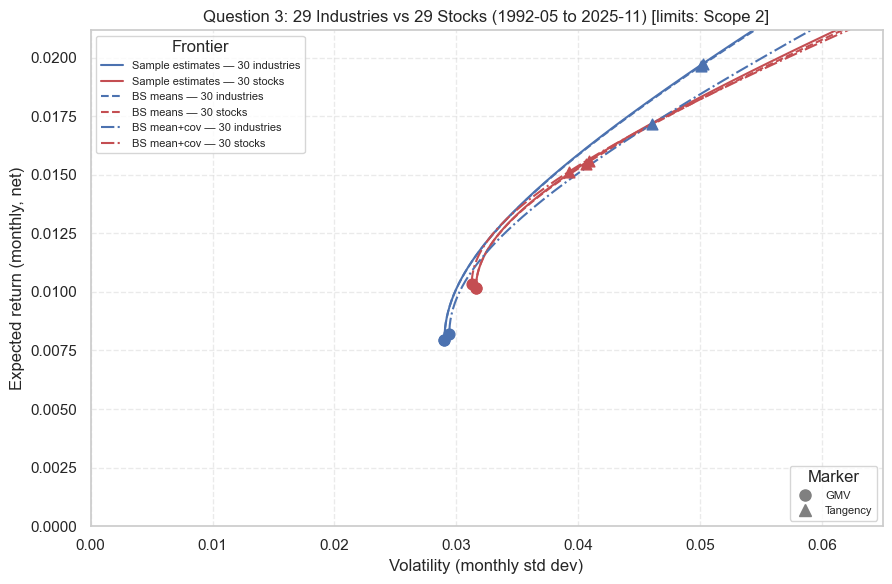

In [11]:
# Scope 3 baseline plots
fig_scope3_with_coal = plot_scope3_overlay(scope3_with_coal, **PLOT_DEFAULTS)
fig_scope3_drop_coal = plot_scope3_overlay(scope3_drop_coal, **PLOT_DEFAULTS)

# 3rd plot: with_coal_30 on drop_coal_29 axis limits
drop_xlim = fig_scope3_drop_coal.axes[0].get_xlim()
drop_ylim = fig_scope3_drop_coal.axes[0].get_ylim()
fig_scope3_with_on_drop_limits = plot_scope3_overlay(scope3_with_coal, **PLOT_DEFAULTS)
ax3 = fig_scope3_with_on_drop_limits.axes[0]
ax3.set_xlim(drop_xlim)
ax3.set_ylim(drop_ylim)
ax3.set_title(ax3.get_title() + ' [limits: drop_coal_29]')

# 4th and 5th plots: both Scope 3 scenarios on Scope 2 axis limits
import matplotlib.pyplot as plt
fig_scope2_limits = plot_scope2_overlay(scope2, **PLOT_DEFAULTS)
scope2_xlim = fig_scope2_limits.axes[0].get_xlim()
scope2_ylim = fig_scope2_limits.axes[0].get_ylim()
plt.close(fig_scope2_limits)

fig_scope3_with_on_scope2_limits = plot_scope3_overlay(scope3_with_coal, **PLOT_DEFAULTS)
ax4 = fig_scope3_with_on_scope2_limits.axes[0]
ax4.set_xlim(scope2_xlim)
ax4.set_ylim(scope2_ylim)
ax4.set_title(ax4.get_title() + ' [limits: Scope 2]')

fig_scope3_drop_on_scope2_limits = plot_scope3_overlay(scope3_drop_coal, **PLOT_DEFAULTS)
ax5 = fig_scope3_drop_on_scope2_limits.axes[0]
ax5.set_xlim(scope2_xlim)
ax5.set_ylim(scope2_ylim)
ax5.set_title(ax5.get_title() + ' [limits: Scope 2]')


## Scope 4 - 30 Industries + Risk-Free Asset

In [12]:
scope4 = run_scope4_industries_with_rf(ind, rf_gross)
scope4['inputs']

{'start': '1980-01',
 'end': '2025-12',
 'n_obs': 552,
 'n_assets': 30,
 'rf_mean': 0.003297282608695647}

In [13]:
scope4['summary_tables']['gmv_tan']

,universe,portfolio,mean,vol,excess_mean,sharpe
0,industries,GMV,0.009733,0.031396,0.006435,0.204973
1,industries,TAN,0.017633,0.046860,0.014336,0.305928


In [14]:
scope4['diagnostics']

{'note': 'Scope 4 efficient set combines risky frontier and CML through tangency.'}

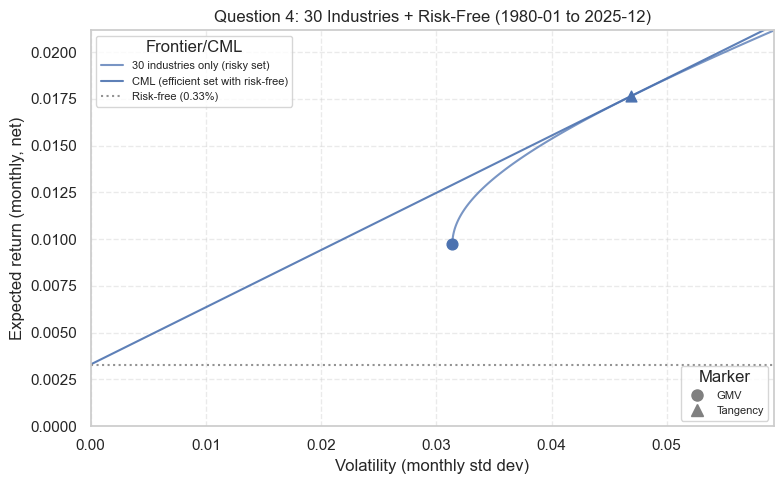

In [15]:
_ = plot_scope4_with_rf(scope4, efficient_frontier_only=PLOT_DEFAULTS['efficient_frontier_only'])

## Scope 5 - Industries vs FF3 vs FF5 (Excess Space)

In [16]:
scope5 = run_scope5_industries_vs_ff(ind, ff3, ff5, rf_gross)
scope5['inputs']

{'start': '1980-01',
 'end': '2025-12',
 'n_obs': 552,
 'space': 'excess returns (rf=0)'}

In [17]:
scope5['summary_tables']['gmv_tan']

,series,universe,portfolio,mean,vol,excess_mean,sharpe
0,industries,industries,GMV,0.006419,0.031293,0.006419,0.205124
1,industries,industries,TAN,0.014287,0.046686,0.014287,0.306029
2,ff3,ff3,GMV,0.002278,0.017905,0.002278,0.127250
3,ff3,ff3,TAN,0.005357,0.027456,0.005357,0.195126
4,ff5,ff5,GMV,0.002926,0.010810,0.002926,0.270663
5,ff5,ff5,TAN,0.003796,0.012313,0.003796,0.308290


In [18]:
scope5['diagnostics']

{'note': 'Industries are converted to excess returns before comparison to FF3/FF5.'}

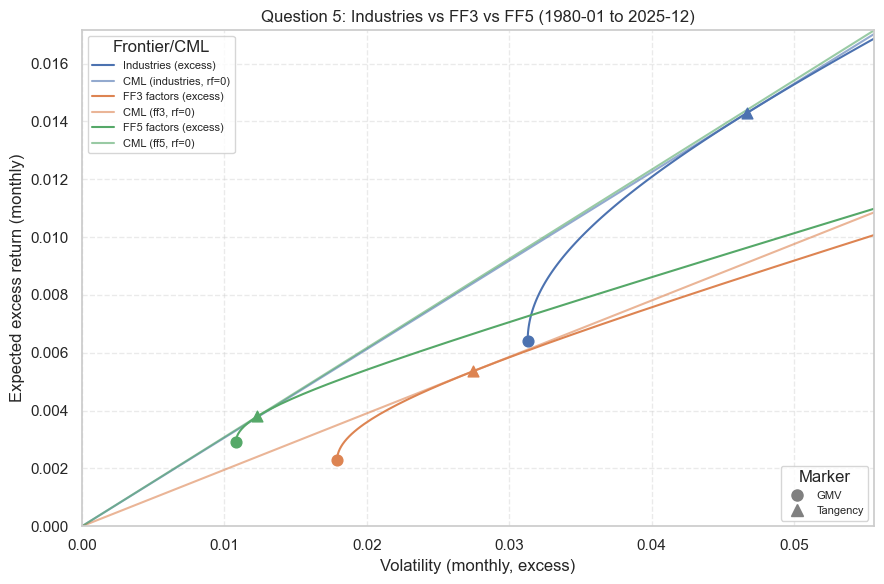

In [19]:
_ = plot_scope5_overlay(scope5, efficient_frontier_only=PLOT_DEFAULTS['efficient_frontier_only'])

## Scope 6 - FF Factors vs Practical Proxies

In [20]:
# Build practical proxy returns (monthly net) from selected ETFs
import yfinance as yf
proxy_tickers = {"Mkt": "VTI", "SMB": "IJR", "HML": "IWD", "RMW": "QUAL", "CMA": "USMV"}
prices = yf.download(list(proxy_tickers.values()), start="2000-01-01", progress=False)["Close"]
monthly_prices = prices.resample("ME").last()
proxy_rets = monthly_prices.pct_change().dropna()
proxy_rets.columns = list(proxy_tickers.keys())
print('Proxy returns:', proxy_rets.shape, proxy_rets.index.min().date(), 'to', proxy_rets.index.max().date())


/var/folders/q2/p314020d117128pmxcyt95z80000gn/T/ipykernel_542/365622258.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(list(proxy_tickers.values()), start="2000-01-01", progress=False)["Close"]


Proxy returns: (151, 5) 2013-08-31 to 2026-02-28


In [21]:
scope6 = run_scope6_ff_vs_proxies(ff3, ff5, proxy_rets, rf_gross, n_points=2000)
scope6['inputs']


{'start': '2013-08',
 'end': '2025-12',
 'n_obs': 149,
 'space': 'excess returns (rf=0)'}

In [22]:
scope6['summary_tables']['gmv_tan']


,series,universe,portfolio,mean,vol,excess_mean,sharpe
0,ff3,ff3,GMV,0.000081,0.021478,0.000081,0.003782
1,ff3,ff3,TAN,0.455651,1.608689,0.455651,0.283244
2,proxy3,proxy3,GMV,0.008176,0.039130,0.008176,0.208936
3,proxy3,proxy3,TAN,0.012915,0.049180,0.012915,0.262602
4,ff5,ff5,GMV,0.000779,0.011955,0.000779,0.065170
5,ff5,ff5,TAN,0.016208,0.054528,0.016208,0.297239
6,proxy5,proxy5,GMV,0.007456,0.032430,0.007456,0.229907
7,proxy5,proxy5,TAN,0.012694,0.042314,0.012694,0.299984


In [23]:
scope6['diagnostics']


{'ff3_tan_unconstrained_mean': 0.4556509731341109,
 'ff3_tan_unconstrained_vol': 1.6086890003290468,
 'ff3_tan_unconstrained_sharpe': 0.2832436680060039,
 'ff3_tan_unconstrained_weights': array([ 37.82813025, -32.50139156,  -4.3267387 ]),
 'ff3_tan_constrained_wmin': -1.0,
 'ff3_tan_constrained_mean': 0.02300144730051271,
 'ff3_tan_constrained_vol': 0.0839675377283272,
 'ff3_tan_constrained_sharpe': 0.27393261637530386,
 'note': 'Proxies are converted to excess returns by subtracting RF.'}

In [24]:
# FF3 tangency note (unconstrained solution can be economically infeasible)
w_ff3_tan = scope6["diagnostics"]["ff3_tan_unconstrained_weights"]
print(
    "FF3 tangency (unconstrained) likely unfeasible: "
    f"mean={scope6['diagnostics']['ff3_tan_unconstrained_mean']:.6f}, "
    f"vol={scope6['diagnostics']['ff3_tan_unconstrained_vol']:.6f}, "
    f"weights={w_ff3_tan}"
)


FF3 tangency (unconstrained) likely unfeasible: mean=0.455651, vol=1.608689, weights=[ 37.82813025 -32.50139156  -4.3267387 ]


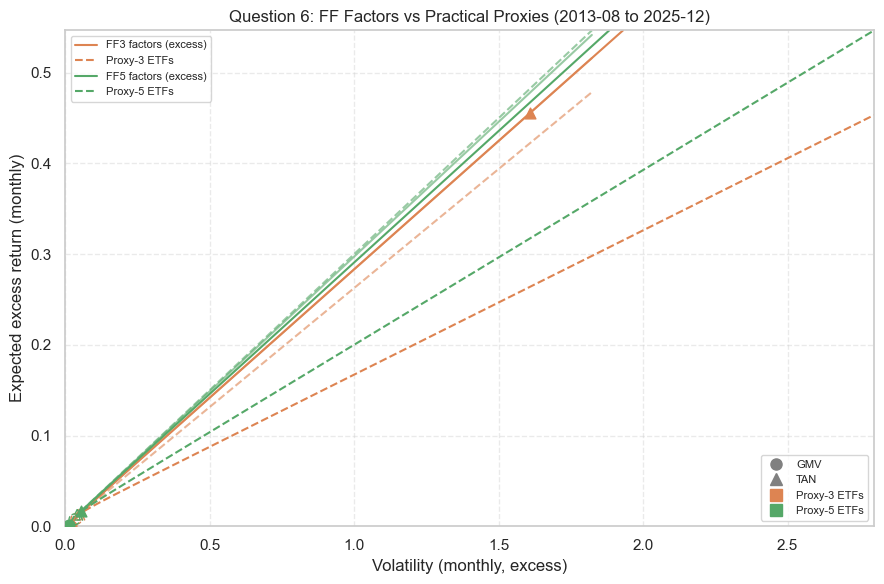

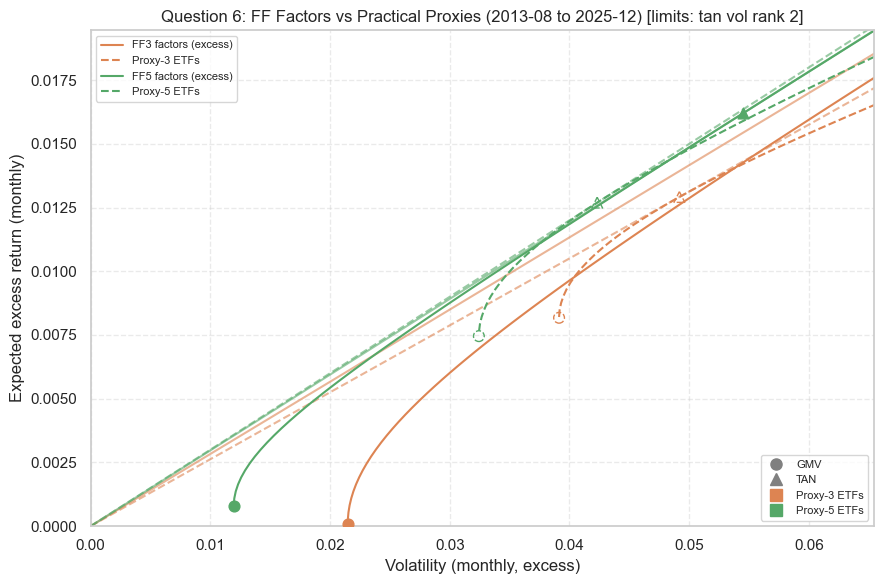

In [25]:
_ = plot_scope6_overlay(scope6, efficient_frontier_only=PLOT_DEFAULTS['efficient_frontier_only'])

_ = plot_scope6_overlay(scope6, limit_basis='tangency_vol_rank', tan_vol_rank=2, efficient_frontier_only=PLOT_DEFAULTS['efficient_frontier_only'])

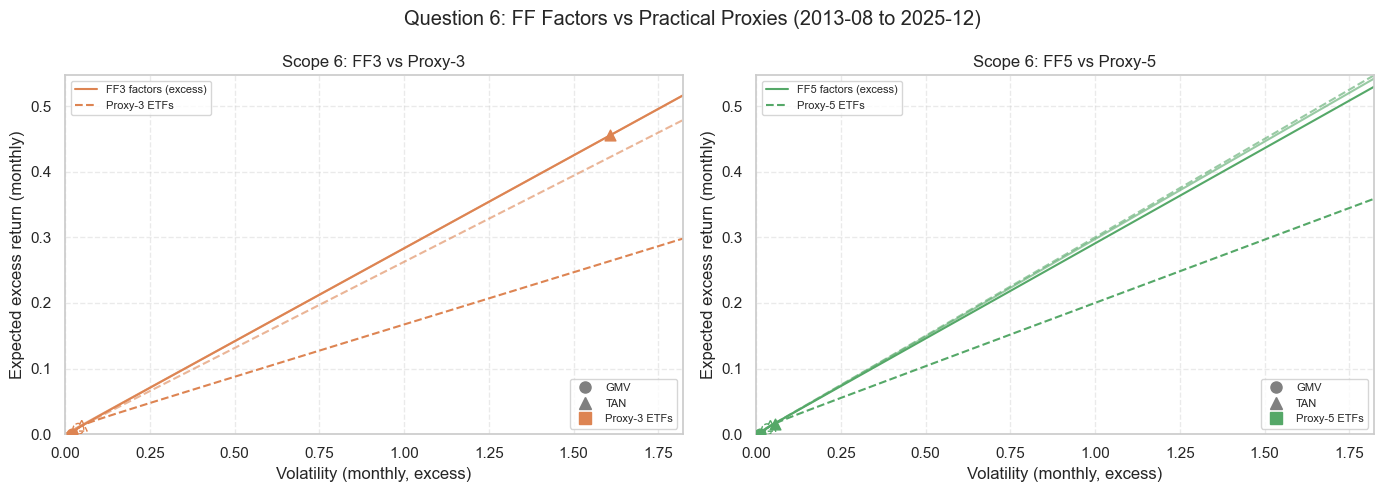

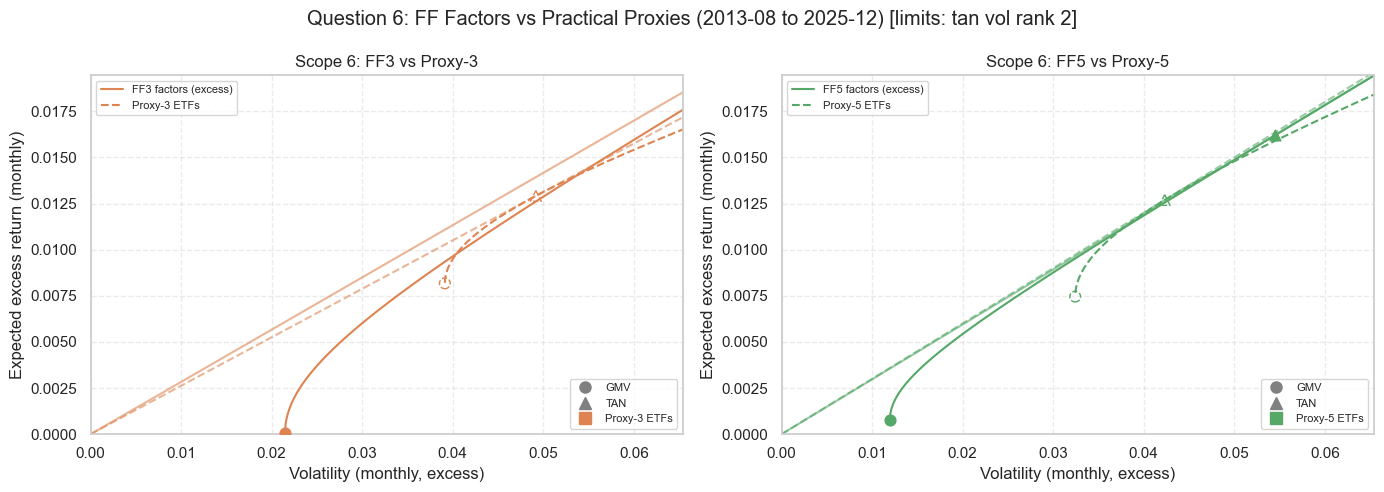

In [26]:
_ = plot_scope6_panels(scope6, efficient_frontier_only=PLOT_DEFAULTS['efficient_frontier_only'])
_ = plot_scope6_panels(scope6, efficient_frontier_only=PLOT_DEFAULTS['efficient_frontier_only'], limit_basis='tangency_vol_rank', tan_vol_rank=2)

## Scope 7 - In-sample / Out-of-sample Sharpe Stability

In [27]:
scope7 = run_scope7_is_oos_tests(ind_gross=ind, ff5_excess=ff5, rf_gross=rf_gross, end_is='2002-12', start_oos='2003-01', end_oos='2025-12')
scope7['inputs']

{'end_is': '2002-12',
 'start_oos': '2003-01',
 'end_oos': '2025-12',
 'industry_is_start': '1980-01',
 'industry_is_end': '2002-12',
 'industry_oos_start': '2003-01',
 'industry_oos_end': '2025-12',
 'ff5_is_start': '1980-01',
 'ff5_is_end': '2002-12',
 'ff5_oos_start': '2003-01',
 'ff5_oos_end': '2025-12',
 'n_ind_is': 276,
 'n_ind_oos': 276,
 'n_ff5_is': 276,
 'n_ff5_oos': 276,
 'rf_ind_is_mean': 0.005246739130434777,
 'rf_ind_oos_mean': 0.0013478260869565174}

In [28]:
scope7['summary_tables']['is_points']

,portfolio,asset_set,mean_is,vol_is,sharpe_is
0,30 ind TAN,industries,0.025766,0.060917,0.337291
1,30 ind GMV,industries,0.010694,0.031386,0.174352
2,FF5 TAN,ff5_excess,0.004326,0.010829,0.399498
3,FF5 GMV,ff5_excess,0.003892,0.010271,0.378917


In [29]:
scope7['summary_tables']['sharpe_is_oos']

,portfolio,sr_is,sr_oos,delta
0,30 ind TAN,0.337291,0.081338,-0.255953
1,30 ind GMV,0.174352,0.165024,-0.009328
2,FF5 TAN,0.399498,0.198728,-0.200770
3,FF5 GMV,0.378917,0.178208,-0.200709


In [30]:
scope7['summary_tables']['jk_tests']

,portfolio,sr_is,sr_oos,z_stat,pvalue
0,30 ind TAN,0.336835,0.081486,2.955630,0.003120
1,30 ind GMV,0.173547,0.165300,0.096195,0.923365
2,FF5 TAN,0.399498,0.198728,2.301921,0.021340
3,FF5 GMV,0.378917,0.178208,2.307759,0.021013


In [31]:
scope7['summary_tables']['lw_tests']

,portfolio,sr_is,sr_oos,diff,ci_low,ci_high,pvalue
0,30 ind TAN,0.336835,0.081486,0.255349,0.110046,0.412355,0.000
1,30 ind GMV,0.173547,0.165300,0.008247,-0.155971,0.177339,0.950
2,FF5 TAN,0.399498,0.198728,0.200770,0.021798,0.384555,0.031
3,FF5 GMV,0.378917,0.178208,0.200709,0.007912,0.402441,0.042


In [32]:
scope7['summary_tables']['frontier_replication']

,portfolio,alpha,r_squared,residual_norm
0,30 ind TAN,1.225348,0.111570,1.793423
1,30 ind GMV,0.965520,-0.073564,0.833263
2,FF5 TAN,0.807486,0.110720,0.282608
3,FF5 GMV,0.968557,-0.015018,0.238164


## Next Sections

Scope 6 plotting/workflow migration is next. Scope 8 and Scope 9 are required and will be migrated in a later tranche.